# Prediction of Disaster Tweets

From Kaggle Comptetion description:
"Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies). (...)
In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified."

### Import Python libraries:

In [33]:
import numpy as np
import pandas as pd
import os
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

from sklearn import feature_extraction, linear_model, model_selection, preprocessing, metrics

### Load the data

In [2]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

### Data Exploration

In [3]:
train_df.shape

(7613, 5)

In [4]:
train_df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_df.count()

id          7613
keyword     7552
location    5080
text        7613
target      7613
dtype: int64

Example of non-disaster Tweet:

In [6]:
train_df.loc[train_df['target'] == 0].iloc[0]['text']

"What's up man?"

Example of disaster Tweet:

In [7]:
train_df.loc[train_df['target'] == 1].iloc[2]['text']

"All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"

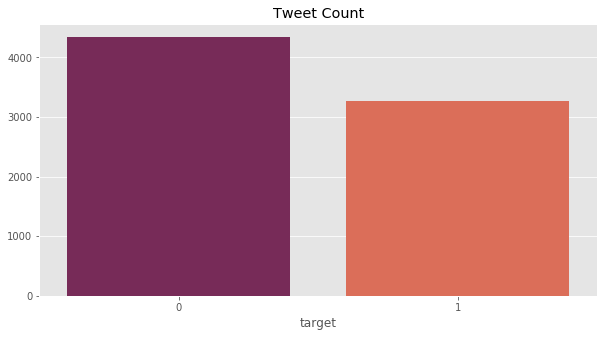

In [8]:
df_count = train_df.groupby('target')['text'].count()

plt.figure(figsize=(10,5))
plt.title('Tweet Count')
sns.barplot(x=df_count.index, y=df_count.values, palette="rocket");

### Keyword counts 

For disaster Tweets, the 3 most frequent keywords are:

<ol>
    <li> wreckage </li>
    <li> derailment </li>
    <li> outbreak </li>
</ol>

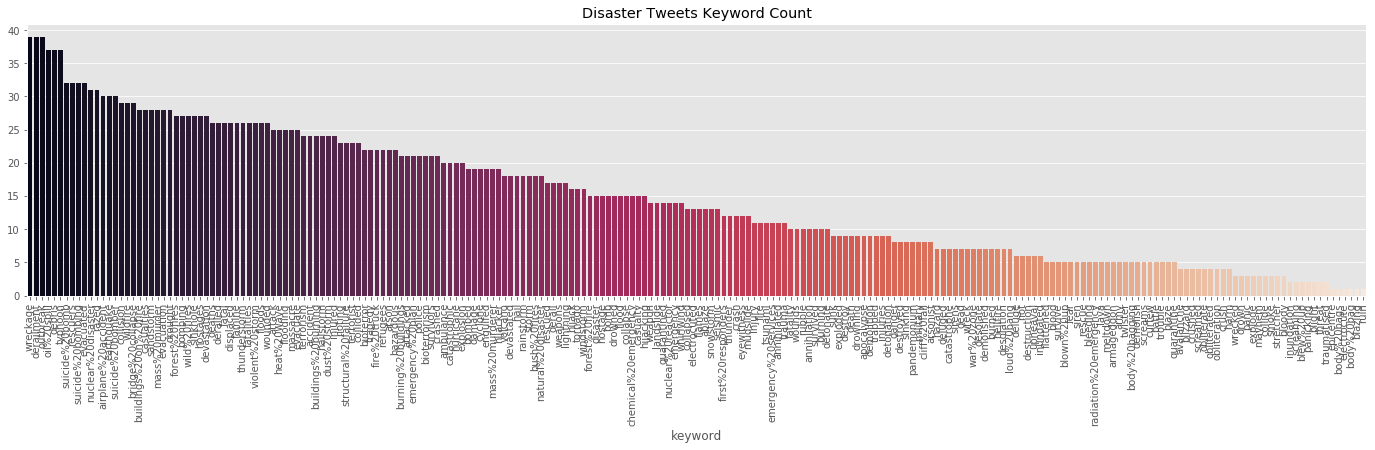

In [9]:
df_kw_dis = train_df[train_df.target == 1].groupby('keyword')['id'].count()
df_kw_dis.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(24,5))
plt.title('Disaster Tweets Keyword Count')
sns.barplot(x=df_kw_dis.index, y=df_kw_dis.values, palette="rocket");
plt.xticks(rotation=90);

For non-disaster Tweets, the 3 most frequent keywords are:

<ol>
    <li> body-bags </li>
    <li> harm </li>
    <li> armageddon </li>
<7ol>

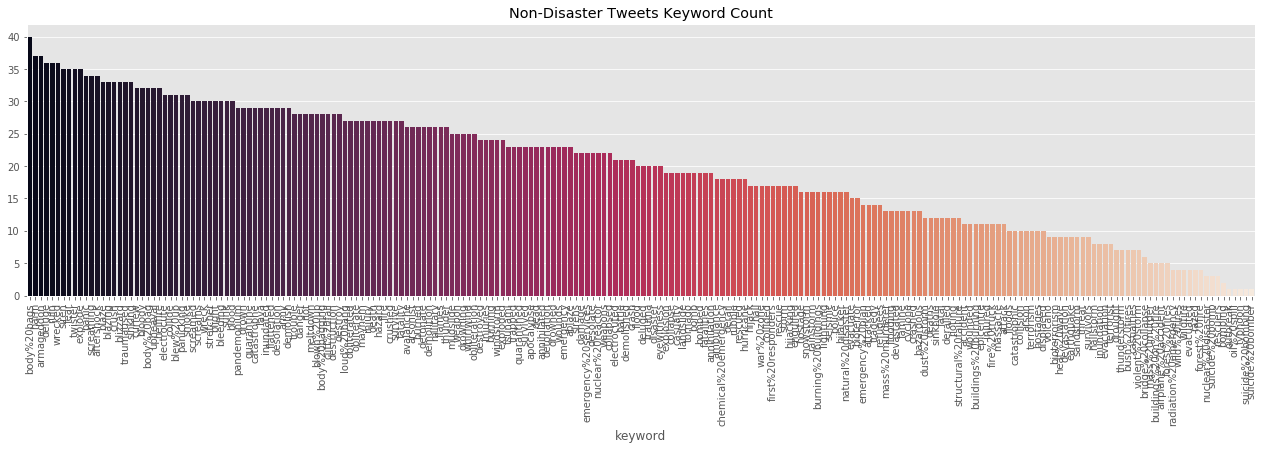

In [10]:
df_kw_ndis = train_df[train_df.target == 0].groupby('keyword')['id'].count()
df_kw_ndis.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(22,5))
plt.title('Non-Disaster Tweets Keyword Count')
sns.barplot(x=df_kw_ndis.index, y=df_kw_ndis.values, palette="rocket");
plt.xticks(rotation=90);

### Distribution of Tweet Character Length


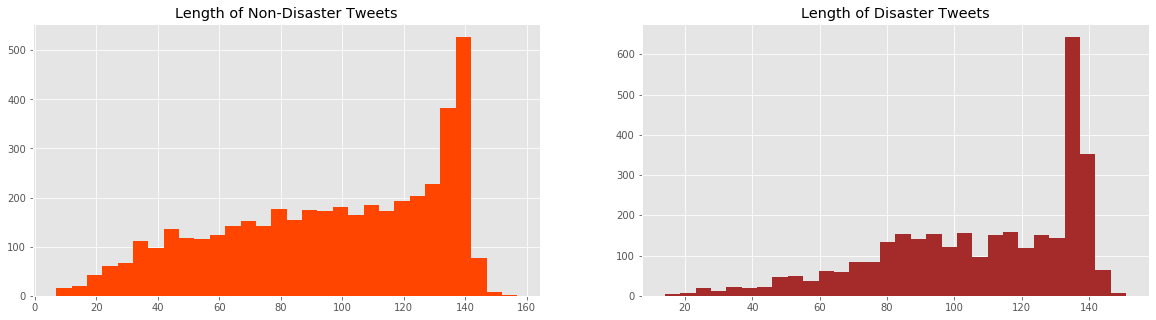

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))

ax[0].hist(train_df[train_df['target'] == 0]['text'].str.len(), color='orangered', bins=30)
ax[0].set_title("Length of Non-Disaster Tweets");

ax[1].hist(train_df[train_df['target'] == 1]['text'].str.len(), color='brown', bins=30)
ax[1].set_title("Length of Disaster Tweets");

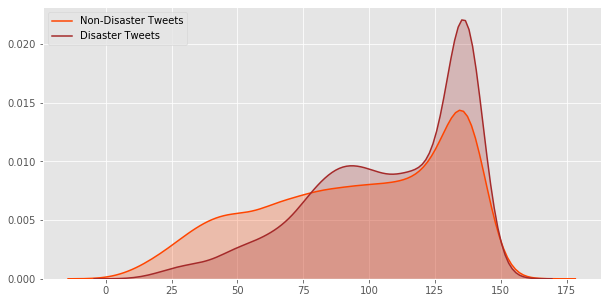

In [12]:
plt.figure(figsize=(10,5))
sns.kdeplot(data=train_df[train_df['target'] == 0]['text'].str.len(), label='Non-Disaster Tweets', color='orangered', shade=True);
sns.kdeplot(data=train_df[train_df['target'] == 1]['text'].str.len(), label='Disaster Tweets', color='brown', shade=True);

### Distribution of Number of Words


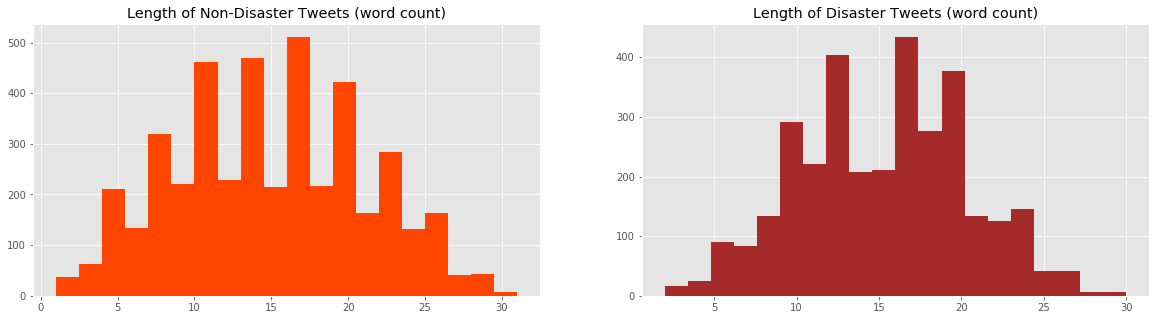

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))

ax[0].hist(train_df[train_df['target'] == 0]['text'].str.split().map(lambda x: len(x)), color='orangered', bins=20)
ax[0].set_title("Length of Non-Disaster Tweets (word count)");

ax[1].hist(train_df[train_df['target'] == 1]['text'].str.split().map(lambda x: len(x)), color='brown', bins=20)
ax[1].set_title("Length of Disaster Tweets (word count)");

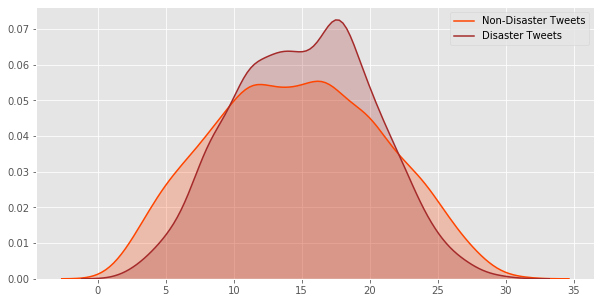

In [14]:
plt.figure(figsize=(10,5))
sns.kdeplot(data=train_df[train_df['target'] == 0]['text'].str.split().map(lambda x: len(x)), label='Non-Disaster Tweets', color='orangered', shade=True);
sns.kdeplot(data=train_df[train_df['target'] == 1]['text'].str.split().map(lambda x: len(x)), label='Disaster Tweets', color='brown', shade=True);

In [15]:
train_df['keyword'].value_counts()

fatalities               45
armageddon               42
deluge                   42
damage                   41
body%20bags              41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

### Preprocessing

Apply the **preprocess_tweet** function to all the tweets. This function does the following steps:

<ul>
    <li> Remove old style 'RT' suffix, hyperlinks and hashtags </li>
    <li> Tokenize Tweets </li>
    <li> Remove stopwords </li>
    <li> Apply stemming </li>
</ul>    


In [16]:
from utils import process_tweet

def preprocess_tweet(row):
    # Retrieve row
    text = row['text']
    
    # Clean Tweet text
    text = process_tweet(text)
    
    return text

train_df['text'] = train_df.apply(preprocess_tweet, axis=1)
test_df['text'] = test_df.apply(preprocess_tweet, axis=1)

# Showcase
train_df.head()['text']

0            deed reason earthquak may allah forgiv us
1                 forest fire near la rong sask canada
2    resid ask shelter place notifi offic evacu she...
3    13,000 peopl receiv wildfir evacu order califo...
4    got sent photo rubi alaska smoke wildfir pour ...
Name: text, dtype: object

### Split the initial data into a training set and a validation set

In [18]:
X_train, X_val, y_train, y_val = model_selection.train_test_split(train_df['text'], train_df['target'], test_size=0.1, random_state=100)

X_test = test_df['text']

### Feature Engineering

Text documents will be converted to TF-ID features.

"TF-IDF is an information retrieval technique that weighs a term’s frequency (TF) and its inverse document frequency (IDF). Each word or term that occurs in the text has its respective TF and IDF score. The product of the TF and IDF scores of a term is called the TF-IDF weight of that term."



In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)

X_train_tfidf = tf_idf.fit_transform(X_train)
X_val_tfidf = tf_idf.transform(X_val)
X_test_tfidf = tf_idf.transform(X_test)

### Define an evaluation function, based on F1 Score

In [38]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_CV_score(model, nfolds, metric='f1'):
    """
    Return the average F1 score from cross-validation.
    Params:
        - model: model to evaluate
        - nfolds: number of folds to run CV with
        - metric to use for CV scoring (defaults to 'f1')
    """
    
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(nfolds, shuffle=True, random_state=100)

    # Get scores
    ret_score = cross_val_score(model, X_train_tfidf, y_train, scoring=metric, cv=kf)

    return ret_score.mean()


### Get best parameters

Best alpha:  0.1


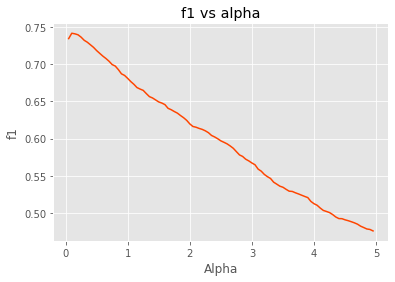

In [52]:
from sklearn.naive_bayes import MultinomialNB

nfolds = 3
metric = 'f1'

res = pd.Series([get_CV_score(MultinomialNB(alpha=i), nfolds=nfolds, metric=metric) for i in np.arange(0.05, 5, 0.05)], 
                index=np.arange(0.05, 5, 0.05))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

sns.lineplot(x=res.index, y=res.values, color='orangered')
plt.title(metric + ' vs alpha')
plt.xlabel('Alpha')
plt.ylabel(metric)
plt.show()

### Train the model with the best alpha obtained:

In [49]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=best_alpha)
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=1.95, class_prior=None, fit_prior=True)

### Evaluate the results

In [50]:
y_preds = nb_model.predict(X_val_tfidf)

metrics.f1_score(y_val, y_preds)

0.726950354609929

### Save results

In [51]:
sample_submission = pd.read_csv('./data/sample_submission.csv')
sample_submission['target'] = nb_model.predict(X_test_tfidf)
sample_submission.to_csv('./data/submission.csv', index=False)

sample_submission.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1
